In [ ]:
!pip install optimizers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Created wheel for optimizers: filename=Optimizers-2.1-py3-none-any.whl size=2284 sha256=481e7c90d180c05e0d439af85cf7ef0cf126461f189236f9a627b2d7fc23fefd
  Stored in directory: /root/.cache/pip/wheels/56/a5/4d/f679a391b5fca0b18c5e2fcd66ebff8900d97d6d95713915b9
Successfully built optimizers
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.preprocessing import *
import os
from keras.layers.normalization import *
import glob
import cv2
from PIL import Image
from pathlib import Path
from keras.models import Sequential, Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.optimizers import *
from keras.callbacks import *
from keras.utils import *
from sklearn.metrics import confusion_matrix
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print(os.listdir("/content/drive/MyDrive/Colab Notebooks/dataset"))
#interact with the the file system

['test', 'val', 'train']


In [ ]:
data_dir=Path("/content/drive/MyDrive/Colab Notebooks/dataset")
train_dir=data_dir/"/content/drive/MyDrive/Colab Notebooks/dataset/train"
val_dir=data_dir/"/content/drive/MyDrive/Colab Notebooks/dataset/val"
test_dir=data_dir/"/content/drive/MyDrive/Colab Notebooks/dataset/test"





In [ ]:
def load_train():
  normal_cases_dir=train_dir /"/content/drive/MyDrive/Colab Notebooks/dataset/train/normal"
  covid_cases_dir=train_dir / "/content/drive/MyDrive/Colab Notebooks/dataset/train/covid"
  normal_cases=normal_cases_dir.glob('*.jpeg')
  #same pattern a data return korbe
  covid_cases=covid_cases_dir.glob('*.jpeg')
  train_data=[]
  train_label=[]
  for img in normal_cases:
    train_data.append(img)
    train_label.append('Normal') #label korlam normal name a
  for img in covid_cases:
    train_data.append(img)
    train_label.append('Covid') #label korlam covid name

  df=pd.DataFrame(train_data,columns=range(1))
  df.columns=['images']
  df['labels']=train_label
  df=df.sample(frac=1).reset_index(drop=True) #sample function randomly kisu row and column generate kore
  return df

In [ ]:
train_data=load_train()
train_data.shape

(62, 2)

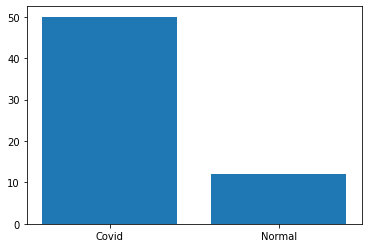

In [ ]:
plt.bar(train_data['labels'].value_counts().index , train_data['labels'].value_counts().values)
plt.show()

In [ ]:
def plot(image_batch,label_batch):
  plt.figure(figsize=(10,5)) #image ar size fig korlam width and height diya
  for i in range(10):
    ax=plt.subplot(2,5,i+1) #2 ta row te 5 ta kore image print hobe
    img=cv2.imread(str(image_batch[i])) #image load hosse
    img=cv2.resize(img,(224,224))
    plt.imshow(img)
    plt.title(label_batch[i])
    plt.axis("off")


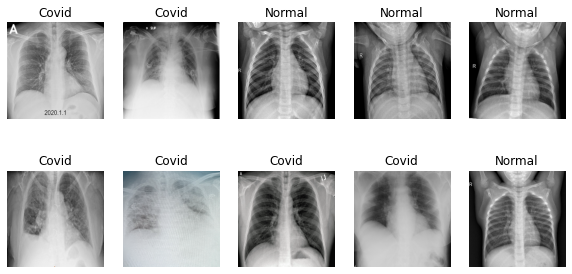

In [ ]:
plot(train_data['images'],train_data['labels'])

In [ ]:
def prepare_and_load(isval=True):
  if isval==True:
    normal_dir=val_dir /'/content/drive/MyDrive/Colab Notebooks/dataset/val/normal'
    covid_dir=val_dir/'/content/drive/MyDrive/Colab Notebooks/dataset/val/covid'
  else:
     normal_dir=test_dir /'/content/drive/MyDrive/Colab Notebooks/dataset/test/normal'
     covid_dir=test_dir/'/content/drive/MyDrive/Colab Notebooks/dataset/test/covid'
  normal_case=normal_dir.glob("*.jpeg")
  covid_case=covid_dir.glob('*.jpeg') #file and folder ar value return kore jader same pattern
  data,labels=([] for x in range(2))#array
  def prepare(case):
    for img in case:
      img=cv2.imread(str(img))
      img=cv2.resize(img,(224,224))
      if img.shape[2]==1:#image jodi gray hoi
        img=np.dstack([img,img,img])#vartically image ghula process hosse
      img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)#img ghula k RGB te covert korlam
      img=img.astype(np.float32)/255 #normalized korlam ,,,converting the values of a dataset to have similar ranges
      if case==normal_case:

        label=to_categorical(0,num_classes=2)#dummy value te convert kore ..thats mean one hot enconding a convert kore
      else:
        label=to_categorical(1,num_classes=2)

        data.append(img)
        labels.append(label)
    return data,labels
  prepare(normal_case)
  d,l=prepare(covid_case)
  d=np.array(d)
  l=np.array(l)
  return d,l








In [ ]:
v_data,v_labels=prepare_and_load(isval=True)
test_data,test_labels = prepare_and_load(isval=False)
print('Number of Test Images: ',len(test_data))
print('Number of Validation Images: ',len(v_data))

Number of Test Images:  47
Number of Validation Images:  14


In [ ]:
def data_gen(data,batch_size):
    #get total Number of sample in data
    n = len(data)
    steps =n//batch_size
    #define two empty arrays for containg batch & label data
    batch_data = np.zeros((batch_size,224,224,3),dtype=np.float32)
    batch_labels = np.zeros((batch_size,2),dtype=np.float32)

    #get a numpy array
    indices = np.arange(n)
    i = 0
    while True:
        np.random.shuffle(indices)
        #Shuffling means changing the position of the elements of the sequence.
        # Here, the shuffling operation is inplace.
        #get the next batch
        count = 0
        next_batch = indices[(i*batch_size):(i-1)*batch_size]
        for j,idx in enumerate(next_batch):
          # Enumerate() method adds a counter to
          #an iterable and returns it in a form of enumerating object.
          #converted into a list of tuples using the list() method.

            img_name = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            if label=='Normal':
                label=0
            else:
                label=1

            #one hot encoding that means 0,1 convert korbo
            encoded_label = to_categorical(label,num_classes=2)
            #num_classes means totall number of classes
            img = cv2.imread(str(img_name))
            img = cv2.resize(img,(224,224))

            #check if its shape is grayscale
            if img.shape[2]==1:
                img = np.dstack([img,img,img])
            #convert color
            orig_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            #NORMALIZE the image pixels
            orig_img = img.astype(np.float32)/255
            batch_data[count]=orig_img
            batch_labels[count]=encoded_label
            count = count +1

            if count==batch_size-1:
              break
        i += 1
        yield batch_data,batch_labels
        #Yield is a keyword in Python that is used to return from a function
        #without destroying the states of its local
         #variable and when the function is called, the execution starts from
          #the last yield statement.
        if i>=steps:
          i=0


In [ ]:
model=Sequential()
#keras sequential which deals with ordering or sequencing of layers within a model.
#that means sequentially data k sajai..
model.add(Conv2D(32,(3,3),input_shape=(224,224,3)))
model.add(Activation('relu'))
#relu :if negative value throug the model relu funtion return 0,
#if positive value dewa hoii relu function ta oi  positive value tai return kore
model.add(MaxPooling2D(pool_size=(2,2)))
#matrices ar modde max value ta niya kaj kore

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
 #convert to 1 dimensions.that means creat a model for output

model.add(Dense(64))
#dense layer ta deeply connected layer ,you can call hidden layer
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))
#softmax is activation function for two features


In [ ]:
batch_size = 15
nb_epochs = 3

#Get trian data genrator
train_data_gen = data_gen(data=train_data,batch_size=batch_size)

#Define number of traing steps
nb_train_steps = train_data.shape[0]//batch_size

print('number of training a validation steps: {} and {}'.format(nb_train_steps,len(v_data)))

number of training a validation steps: 4 and 14


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


#model.compile is related to training your model. Actually, your weights need to optimize and this function can optimize them.
history=model.fit_generator(train_data_gen,epochs=nb_epochs,steps_per_epoch=nb_train_steps,
                            validation_data=(v_data,v_labels))


Epoch 1/3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


4/4 [==============================] - 3s 650ms/step - loss: 10.3725 - accuracy: 0.7333 - val_loss: 0.1148 - val_accuracy: 0.9286
Epoch 2/3
4/4 [==============================] - 1s 318ms/step - loss: 0.2430 - accuracy: 0.9333 - val_loss: 0.1380 - val_accuracy: 0.9286
Epoch 3/3
4/4 [==============================] - 1s 386ms/step - loss: 0.0416 - accuracy: 0.9333 - val_loss: 0.1540 - val_accuracy: 0.9286


In [ ]:



# VGG16 is an efficient deep learning model for image classification with 16 layers.
# The model is also widely used as an image-feature extractor in a transfer learning
#
def vgg16_model(num_classes=None):
    model = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))

    x = Dense(1024,activation='relu')(model.layers[-4].output)
    x = Dropout(0.7)(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.5)(x)#dropout ta kora hoi mainly overfitting komanor jonno
    x = Dense(2,activation='softmax')(x)
   # model = Model(input=input, output=x)
    model = tf.keras.Model(model.input, outputs=x)
    #return model
    return model


In [ ]:

vgg_conv = vgg16_model(2)
for y in vgg_conv.layers[:-10]:
   y.trainable = False



553476096/553467096 [==============================] - 3s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001,decay=1e-5)
vgg_conv.compile(loss='binary_crossentropy',
                 metrics=['accuracy'],
                 optimizer=opt)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history=model.fit_generator(train_data_gen,epochs=nb_epochs,steps_per_epoch=nb_train_steps,
                            validation_data=(v_data,v_labels),class_weight={0:1.0,1:0.4})

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


4/4 [==============================] - 2s 681ms/step - loss: 0.0393 - accuracy: 0.9667 - val_loss: 0.2490 - val_accuracy: 0.9286
Epoch 2/3
4/4 [==============================] - 0s 133ms/step - loss: 0.0158 - accuracy: 0.9333 - val_loss: 0.2587 - val_accuracy: 0.9286
Epoch 3/3
4/4 [==============================] - 1s 311ms/step - loss: 0.0092 - accuracy: 0.9500 - val_loss: 0.1432 - val_accuracy: 0.9286


In [ ]:
loss,acc=vgg_conv.evaluate(test_data,test_labels,batch_size=15)
print("loss and accuracy ",loss,"and",acc)

4/4 [==============================] - 3s 286ms/step - loss: 0.6931 - accuracy: 0.6170
loss and accuracy  0.6931437253952026 and 0.6170212626457214


In [ ]:
#get pridictions
pred=vgg_conv.predict(test_data,batch_size=12)
pred=np.argmax(pred,axis=-1)
#original labels
labels=np.argmax(test_labels,axis=-1)
from sklearn.metrics import classification_report
print(classification_report(labels,pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        47

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47

